<a href="https://colab.research.google.com/github/Mubashar-Bashir/AgenticAI/blob/main/Excise_final_AIAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: pip install langchain, langraph, google_genai, !pip install requests beautifulsoup4
%%capture --no-stderr
!pip install  -q -U  langchain
!pip install  -q -U langgraph
!pip install -q -U langchain-google-genai
#!pip install -q -U requests beautifulsoup4


In [9]:
import os
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')

# Recommended approach: Get API keys from environment variables

# Check if API keys are found
if not GEMINI_API_KEY or not LANGCHAIN_API_KEY:
    raise ValueError("API keys not found. Please set the GEMINI_API_KEY and LANGCHAIN_API_KEY environment variables.")

In [15]:
%pip install -qU langchain-google-genai

In [10]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize an instance of the ChatGoogleGenerativeAI with specific parameters
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",  # Specify the model to use
    api_key=GEMINI_API_KEY,     # Provide the Google API key for authentication
)

In [13]:
# Generate a response from the LLM
response = llm.invoke("Hello, how are you today?")
print(response.content)

I am doing well, thank you for asking!  How are you today?



In [14]:
from typing_extensions import TypedDict, Literal

class State(TypedDict):
    query: str  # User's input query
    category: Literal["MVR", "UIPT", "Prof Tax", "HIPT", "Excise-Duty", "Cotton_Fee", "General"]
    department: list[str]  # Departments relevant to the query or response
    sub_department: Literal["Motor Vehicles Registration", "UIPT", "HIPT","Professional Tax", "Excise"]
    summary: str  # Summarized conversation for reducing token usage
    messages: list  # Full list of messages for maintaining context


In [56]:
# Sample configuration for the checkpointer (if you need to persist state)
# config = {
#     "thread_id": "test_thread",  # Unique thread identifier
#     "checkpoint_ns": "test_ns",  # Namespace for the checkpoint
#     "checkpoint_id": "test_checkpoint",  # Unique checkpoint identifier
# }

# compiled_graph = builder.compile(checkpointer=memory, config=config)

In [69]:
# from langgraph.checkpoint.memory import MemorySaver
# from langgraph.graph.state import StateGraph


# memory: MemorySaver = MemorySaver()
# # react_graph_memory: CompiledStateGraph = builder.compile(checkpointer=memory)

# # Define the categorization function
# def categorize_with_memory(state: State) -> State:
#     """Categorize the customer query into predefined categories using structured output."""
#     # Extract query
#     query = state["query"]

#     # Retrieve previous memory (if any)
#     previous_memory = memory.get("conversation_memory", None)

#     # If memory exists, append it to the current query for context
#     if previous_memory:
#         query = previous_memory + " " + query

#     # Categorize the query
#     category = categorize(state)  # This is a previously defined method
#     state["category"] = category["category"]

#     # Save the new memory (current state) for future use
#     memory.set("conversation_memory", query)

#     return state

In [37]:
from typing import Literal
from langchain.prompts import ChatPromptTemplate

# Define the categorize function
def categorize(state: State) -> State:
    """
    Categorize the customer query into predefined categories using structured output.
    Categories: ["MVR", "UIPT", "Prof Tax", "HIPT", "Excise-Duty", "Cotton_Fee", "General"]
    """
    # Define the schema for structured output using Literal
    schema = {
        "category": Literal[
            "MVR", "UIPT", "Prof Tax", "HIPT", "Excise-Duty", "Cotton_Fee", "General"
        ]
    }

    # Create the LLM with structured output capability
    structured_llm = llm.with_structured_output(schema)

    # Define the prompt template
    prompt_template = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories and department: "
        "MVR, UIPT, Prof Tax, HIPT, Excise-Duty, Cotton_Fee, General.\n"
        "Motor Vehicles Registration,UIPT, HIPT,Professional Tax, Excise.\n"
        "Query: {query}"
    )

    # Format the prompt with the user's query
    prompt = prompt_template.format(query=state["query"])
    print('Prompt Format with User Query')
    # Invoke the structured LLM with the prompt
    response = structured_llm.invoke(prompt)

    # Update the state with the structured category result
    state["category"] = response.category
    state["department"] = response.category

    return state


In [38]:


# Step 2: Add Tools (Placeholder Functions for Excise Tasks)
def vehicle_verification(vehicle_Reg_no: str) -> str:
    """Verify vehicle registration."""
    return f"Vehicle {vehicle_Reg_no} is verified."

def calculate_tax(invoice_value: float) -> str:
    """Calculate tax."""
    return f"The tax on {invoice_value} is {invoice_value * 0.1}."

def calculate_transfer_fee(vehicle_Reg_no: str) -> str:
    """Calculate transfer fee."""
    return f"The transfer fee on {vehicle_Reg_no} is {10000}."

tools = [vehicle_verification, calculate_tax,calculate_transfer_fee]

# Bind Tools to LLM
llm_with_tools = llm.bind_tools(tools)

In [39]:
response = llm_with_tools.invoke("What is the tax on a vehicle worth Rs. 500,000?")
print(response)
response.pretty_print

content='' additional_kwargs={'function_call': {'name': 'calculate_tax', 'arguments': '{"invoice_value": 500000.0}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-c1de842f-18af-47e8-9353-f74003c19ea7-0' tool_calls=[{'name': 'calculate_tax', 'args': {'invoice_value': 500000.0}, 'id': '12907094-1412-42c4-b714-f02b7e220e6b', 'type': 'tool_call'}] usage_metadata={'input_tokens': 149, 'output_tokens': 6, 'total_tokens': 155, 'input_token_details': {'cache_read': 0}}


<bound method BaseMessage.pretty_print of AIMessage(content='', additional_kwargs={'function_call': {'name': 'calculate_tax', 'arguments': '{"invoice_value": 500000.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-c1de842f-18af-47e8-9353-f74003c19ea7-0', tool_calls=[{'name': 'calculate_tax', 'args': {'invoice_value': 500000.0}, 'id': '12907094-1412-42c4-b714-f02b7e220e6b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 6, 'total_tokens': 155, 'input_token_details': {'cache_read': 0}})>

In [40]:

# Assuming `categorize` and other parts are already implemented

# Create additional nodes for each category
def mvr_handler(state: State) -> State:
    """Handle MVR-related queries"""
    category = state["category"]
    query = state["query"]
    response = llm_with_tools.invoke(query)
    state["response"] = response
    return state

# def uipt_handler(state: State) -> State:
#     """Handle UIPT-related queries"""
#     state["response"] = "This is the UIPT/ Urban Immoveble Property Tax response."
#     return state

# def hipt_handler(state: State) -> State:
#     """Handle HIPT-related queries"""
#     state["response"] = "This is the (Highway Immoveable Property Tax)HIPT response."
#     return state

# def prof_tax_handler(state: State) -> State:
#     """Handle Professional Tax-related queries"""
#     state["response"] = "This is the Professional Tax response."
#     return state

# def excise_duty_handler(state: State) -> State:
#     """Handle Excise Duty-related queries"""
#     state["response"] = "This is the Excise Duty response."
#     return state

# def cotton_fee_handler(state: State) -> State:
#     """Handle Cotton Fee-related queries"""
#     state["response"] = "This is the Cotton Fee response."
#     return state

# def general_handler(state: State) -> State:
#     """Handle General queries"""
#     state["response"] = "This is the General Excise response."
#     return state


In [41]:

# Define a conditional node that routes based on the category
def category_router(state: State) -> str:
    """Route based on the extracted category."""
    category = state["category"]

    # Conditional Routing: if category is related to Excise or specific taxes, route to ExciseAgent
    if category in ["MVR", "UIPT", "Prof Tax", "HIPT", "Excise-Duty", "Cotton_Fee", "General"]:
        return "excise_agent"

    # Handle other categories, like MVR, UIPT, General, etc.
    elif category == "General":
        return "general_agent"

    return END


In [42]:
from langchain_core.messages import HumanMessage, SystemMessage
# from langchain_tools import excise_tax_tool, vehicle_verification_tool

# Define the Excise Agent node
def excise_agent(state: State) -> State:
    """Handle Excise-specific queries such as Excise-Duty and Cotton_Fee."""

    category = state["category"]

    # Check if it's Excise-Duty or Cotton_Fee
    if category == "Excise-Duty":
        system_message = SystemMessage(content="You are an expert on Excise & Taxation Punjab Excise-Duty. Assist with tax calculations, exemptions, and related queries.")
        # You can use your own tools here (e.g., excise_tax_tool, vehicle_verification_tool, etc.)
        response = llm_with_tools.invoke([system_message, HumanMessage(content=state["query"])])
        # response = llm_with_tools.run([system_message, HumanMessage(content=state["query"])])
    elif category == "Cotton_Fee":
        system_message = SystemMessage(content="You are an expert in Cotton Fee taxation. Answer queries about cotton fees and related regulations.")
        # Use tools for Cotton Fee calculation if applicable
        response = llm_with_tools.invoke([system_message, HumanMessage(content=state["query"])])

    elif category == "MVR":
        system_message = SystemMessage(content="You are an expert in Motor Vehicle Registration taxation Excise Punjab expert. Answer queries about MVR fees and related regulations.")
        # Use tools for MVR Fee calculation if applicable
        response = llm_with_tools.invoke([system_message, HumanMessage(content=state["query"])])

    else:
        system_message = SystemMessage(content="Excise-related queries are being handled. Please specify your query more clearly.")
        response = "Please specify more clearly for Excise related queries."

    # Update state with response
    state["response"] = response
    return state

In [43]:

# Define the General Agent node
def general_agent(state: State) -> State:
    """Handle General queries not related to specific categories."""

    # Create a system message to set the context for general queries
    system_message = SystemMessage(content="You are a general assistant helping with a wide variety of Excise & Taxation queries. "
                                    "You can access and utilize the provided knowledge base to answer general questions, "
                                    "provide basic information about the department, and guide users to relevant resources URL{https://excise.punjab.gov.pk/}.")
    # Process the user's general query
    response = llm_with_tools.invoke([system_message, HumanMessage(content=state["query"])])

    # Update state with the response
    state["response"] = response
    return state

In [44]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph


# Create the workflow graph
builder: StateGraph = StateGraph(State)

# Add Nodes
# builder.add_node("categorize", categorize_with_memory)
builder.add_node("categorize", categorize)
builder.add_node("category_router", category_router)
builder.add_node("excise_agent", excise_agent)
builder.add_node("general_agent", general_agent)
builder.add_node("mvr_handler", mvr_handler)
# builder.add_node("uipt_handler", uipt_handler)
# builder.add_node("hipt_handler", hipt_handler)
# builder.add_node("prof_tax_handler", prof_tax_handler)
# builder.add_node("cotton_fee_handler", cotton_fee_handler)
# builder.add_node("vehicle_verification_agent", vehicle_verification_agent)
# builder.add_node("calculate_tax_agent", calculate_tax_agent)


# Define the routing from Categorize → Routing → Agent (based on category)
# builder.add_edge("categorize", "category_routing")  # Categorize → Category Routing
# builder.add_conditional_edges("category_routing", lambda state: state["category"] == "Excise-Duty", "general_agent")
# builder.add_conditional_edges("category_routing", lambda state: state["category"] == "General", "general_agent")
# builder.add_conditional_edges("category_routing", lambda state: state["category"] == "MVR", "mvr_handler")
# builder.add_conditional_edges("category_routing", lambda state: state["category"] == "UIPT", "uipt_handler")
# builder.add_conditional_edges("category_routing", lambda state: state["category"] == "Prof Tax", "prof_tax_handler")
# builder.add_conditional_edges("category_routing", lambda state: state["category"] == "HIPT", "hipt_handler")
# builder.add_conditional_edges("category_routing", lambda state: state["category"] == "Cotton_Fee", "cotton_fee_handler")

# Define the routing from Categorize → Routing → Agent (based on category)
builder.add_edge(START,"categorize")
builder.add_edge("categorize", "category_router")  # Categorize → Category Routing

# Ensure unique conditions or condition names
# Ensure unique path names for each condition
# Define the category_routing function for routing based on categories
# def category_routing(state: State) -> str:
#     """Route based on the extracted category."""
#     category = state["category"]

#     # Conditional Routing: Based on the category, return corresponding agent name
#     if category == "Excise-Duty":
#         return "excise_agent"
#     elif category == "General":
#         return "general_agent"
#     elif category == "MVR":
#         return "mvr_agent"
#     elif category == "UIPT":
#         return "uipt_agent"
#     elif category == "Prof Tax":
#         return "prof_tax_agent"
#     elif category == "HIPT":
#         return "hipt_agent"
#     elif category == "Cotton_Fee":
#         return "cotton_fee_agent"

#     # Default: No category matches
#     return "no_matching_agent"


builder.add_conditional_edges(
    "category_router",
    lambda state: state["category"] not in ["Excise-Duty", "General", "MVR", "UIPT", "Prof Tax", "HIPT", "Cotton_Fee"],
    "no_matching_handler"
)

# Optional: Add additional conditions if needed


# Define End State (final node)
builder.add_edge("excise_agent", END)
builder.add_edge("general_agent", END)
builder.add_edge("mvr_handler", END)
# builder.add_edge("uipt_handler", END)
# builder.add_edge("prof_tax_handler", END)
# builder.add_edge("hipt_handler", END)
# builder.add_edge("cotton_fee_handler", END)



In [45]:
# Sample configuration for the checkpointer (if you need to persist state)
# config = {
#     "thread_id": "test_thread",  # Unique thread identifier
#     "checkpoint_ns": "test_ns",  # Namespace for the checkpoint
#     "checkpoint_id": "test_checkpoint",  # Unique checkpoint identifier
# }

compiled_graph = builder.compile()

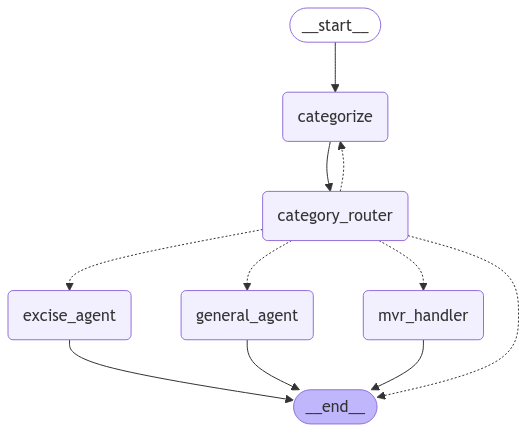

In [46]:
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
display(
    Image(
        compiled_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [47]:
# Define your sample state
sample_state = {
    "query": "Hi",  # User starts with "Hi"
    # "category": "General",  # Initially set to "General"
    # "department": [],
    # "summary": "",
    # "messages": [],
}

In [48]:

# Example of invoking the workflow
test_query = "How can I calculate Excise Duty on my vehicle?"
# test_state = {"query": test_query, "category": "", "department": [], "summary": "", "messages": []}
result = compiled_graph.invoke(sample_state)

# Print out the result
for message in result["messages"]:
    print(message.content)

Prompt Format with User Query


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].name: Invalid function name. Must start with a letter or an underscore. Must be alphameric (a-z, A-Z, 0-9), underscores (_), dots (.) or dashes (-), with a maximum length of 64.


In [49]:
# Initialize the state with the user query
initial_state = {"query": "How do I calculate motor tax for my vehicle?"}

# Execute the workflow
result_state = compiled_graph.invoke(initial_state)

# Print the final response
print(result_state["response"])

Prompt Format with User Query


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].name: Invalid function name. Must start with a letter or an underscore. Must be alphameric (a-z, A-Z, 0-9), underscores (_), dots (.) or dashes (-), with a maximum length of 64.
